In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Step 1: Load the dataset
file_path = '/content/airbnb_Chicago.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Selecting relevant features
features = [
    'host_is_superhost_in_period', 'Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Pets Allowed', 'City_x', 'Zipcode',
    'Neighborhood', 'Nightly Rate', 'Cleaning Fee (USD)', 'Minimum Stay',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'booked_days', 'revenue', 'occupancy_rate'
]

data = data[features]

# Step 2: Preprocess the data
# Handling categorical and numerical features separately
categorical_features = ['Property Type', 'Listing Type', 'City_x', 'Zipcode', 'Neighborhood', 'Pets Allowed']
numerical_features = [col for col in features if col not in categorical_features]

# Building the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Preprocessing the data
X = preprocessor.fit_transform(data)

# Step 3: Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=0)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(X)

# Adding cluster information to the original data
data['Cluster'] = clusters

# Step 4: Analyze the results
# Analyzing the cluster characteristics
cluster_summary = data.groupby('Cluster').mean()

print(cluster_summary)

# Further interpretation of clusters will be based on the average values of features within each cluster.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         host_is_superhost_in_period  Bedrooms  Bathrooms  Max Guests  \
Cluster                                                                 
0                           0.000000  2.031314   1.651464    4.726344   
1                           0.001886  1.237287   1.151879    3.358355   
2                           0.433619  1.206991   1.154519    3.075665   
3                           0.369373  1.864519   1.656360    5.851280   
4                           0.382901  3.066817   2.243538    8.054419   

         Pets Allowed       Zipcode  Nightly Rate  Cleaning Fee (USD)  \
Cluster                                                                 
0            0.000000  60619.530293    237.893669          130.320485   
1            0.183513  60626.488940    121.064273           53.938335   
2            0.159072  60628.480471    120.045347           50.574518   
3            0.261253  60623.548102    142.905833           86.611754   
4            0.233204  60627.080787    356.913681 

<ipython-input-3-e3ef22e00339>:49: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_summary = data.groupby('Cluster').mean()


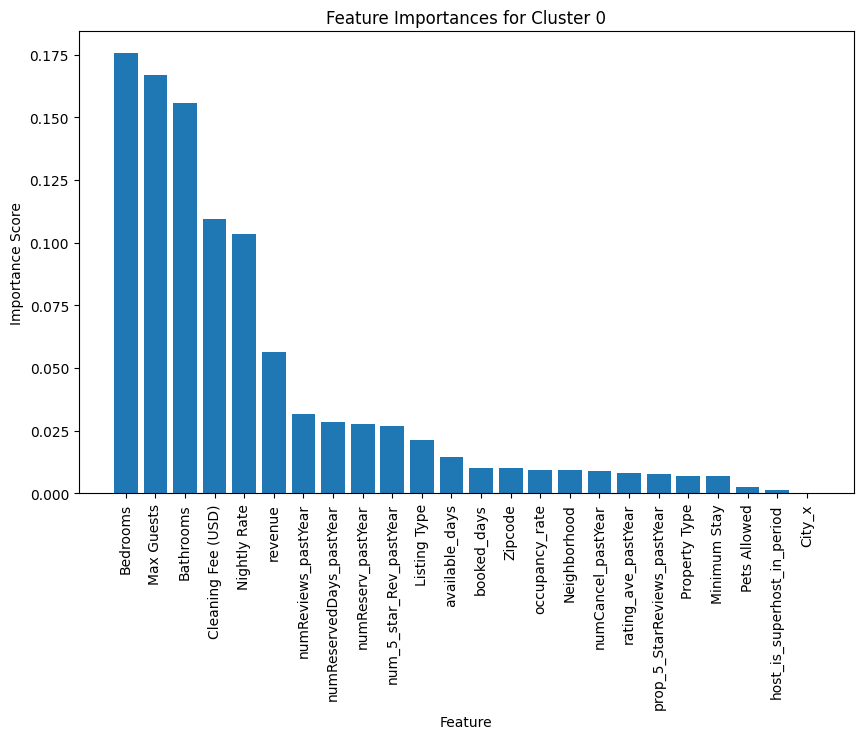

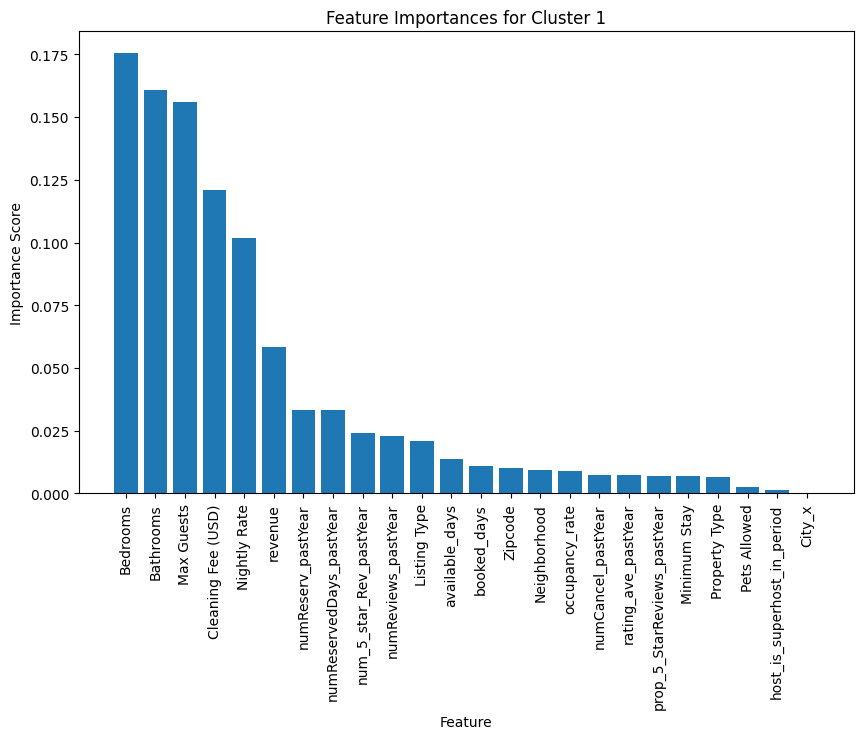

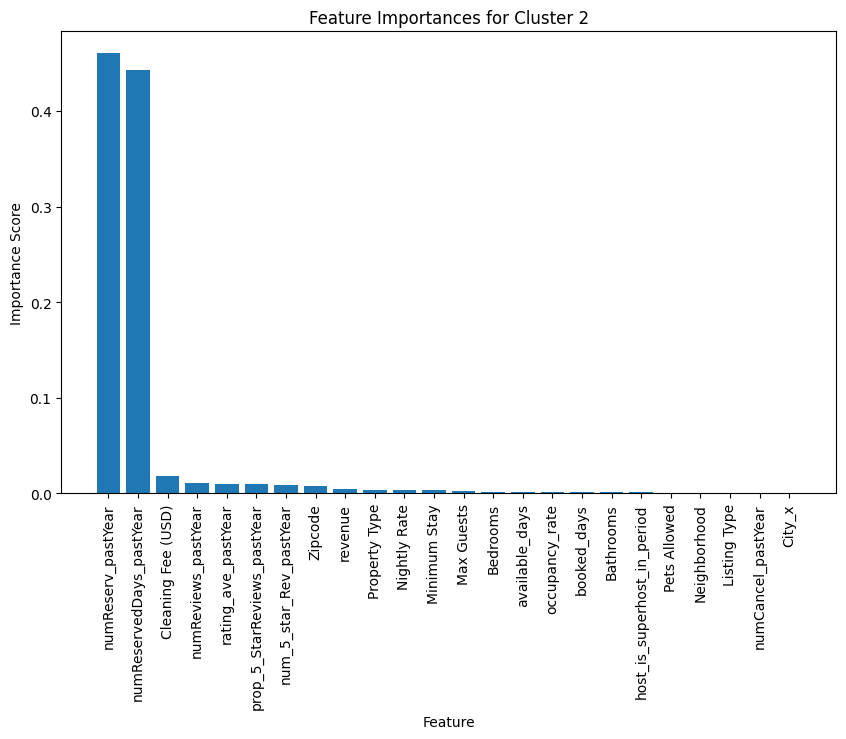

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Convert boolean columns to integer type
bool_columns = data.select_dtypes(include=['bool']).columns
data[bool_columns] = data[bool_columns].astype(int)

# Impute missing values
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Separately impute numerical and categorical features
for col in numerical_features + list(bool_columns):
    data[col] = numerical_imputer.fit_transform(data[[col]])

for col in categorical_features:
    data[col] = categorical_imputer.fit_transform(data[[col]])

# Encoding categorical features
le = LabelEncoder()
encoded_data = data.copy()
for col in categorical_features:
    encoded_data[col] = le.fit_transform(encoded_data[col])

# Create a Random Forest model for each cluster and visualize feature importances
for cluster in range(3):
    # Prepare the target variable - 1 for rows in the cluster, 0 for rows not in the cluster
    target = (encoded_data['Cluster'] == cluster).astype(int)

    # Train a Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(encoded_data[features], target)

    # Extract feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plotting feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances for Cluster {cluster}")
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance Score')
    plt.show()

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from sklearn.impute import SimpleImputer

# Define the feature set including 'Nightly Rate'
features = ['host_is_superhost_in_period', 'Bedrooms', 'Bathrooms', 'Max Guests',
            'Pets Allowed', 'Zipcode', 'Cleaning Fee (USD)', 'Minimum Stay',
            'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
            'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
            'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
            'booked_days', 'revenue', 'Nightly Rate']

optimized_prices = []

for cluster in range(5):  # Assuming there are 5 clusters labeled 0 to 4
    cluster_data = data[data['Cluster'] == cluster]

    # Handle missing values for features and target
    imputer = SimpleImputer(strategy='median')  # or 'mean', depending on your preference
    cluster_data_clean = imputer.fit_transform(cluster_data[features + ['occupancy_rate']])

    # Prepare the feature matrix X and target vector y
    X = cluster_data_clean[:, :-1]  # All columns except the last one
    y = cluster_data_clean[:, -1]   # The last column

    # Train the demand estimation model
    model = LinearRegression()
    model.fit(X, y)

    # Define the revenue function
    def revenue_function(price):
        X_new = X.copy()
        X_new[:, features.index('Nightly Rate')] = price
        estimated_demand = model.predict(X_new)
        return price * np.mean(estimated_demand)

    # Optimize the price
    initial_guess = cluster_data['Nightly Rate'].median()  # Initial guess is the median nightly rate of the cluster
    optimized_price = minimize(lambda x: -revenue_function(x), [initial_guess]).x[0]
    optimized_prices.append(optimized_price)

    print(f"Optimized Price for Cluster {cluster}: ${optimized_price}")

# optimized_prices contains the optimized price for each cluster


Optimized Price for Cluster 0: $2657.310600013068
Optimized Price for Cluster 1: $250.03544952109132
Optimized Price for Cluster 2: $295.78076171875
Optimized Price for Cluster 3: $23681.586846778002
Optimized Price for Cluster 4: $466.16064453125


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


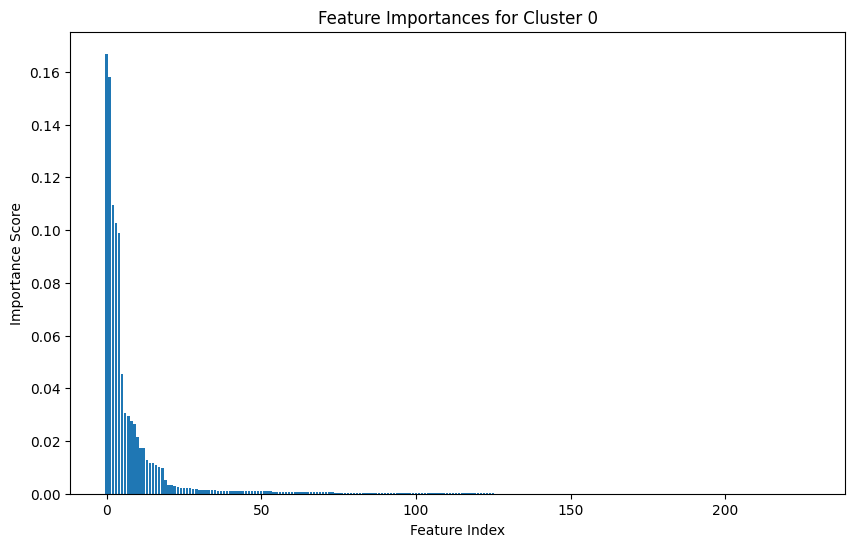

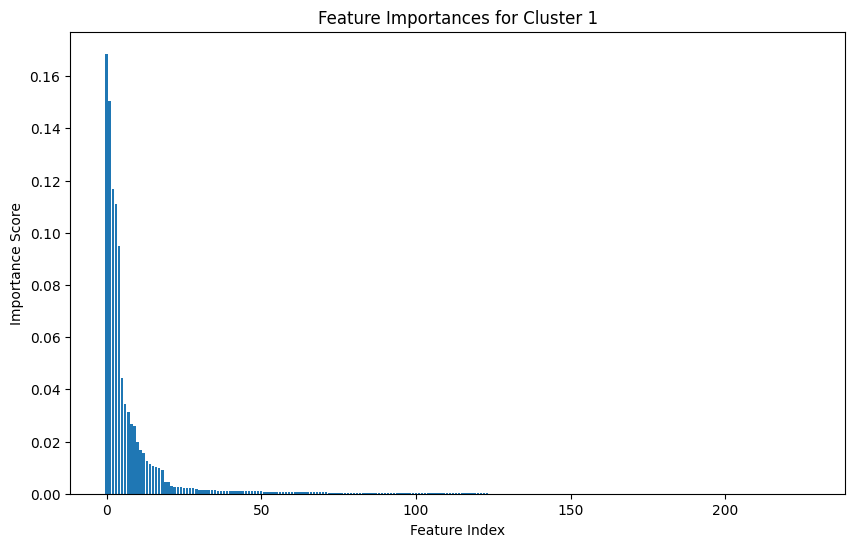

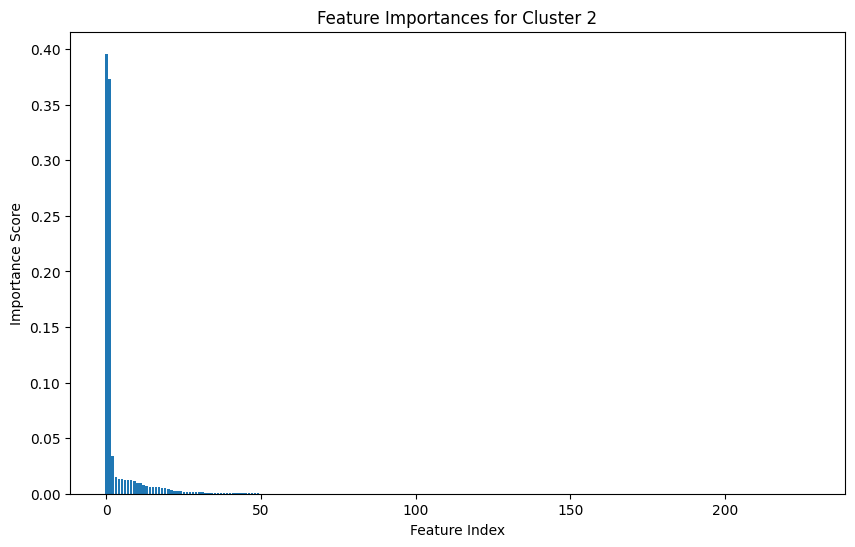

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd

# Load the dataset
file_path = '/content/airbnb_Chicago.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Selecting relevant features
features = [
    'host_is_superhost_in_period', 'Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Pets Allowed', 'City_x', 'Zipcode',
    'Neighborhood', 'Nightly Rate', 'Cleaning Fee (USD)', 'Minimum Stay',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'booked_days', 'revenue', 'occupancy_rate'
]

data = data[features]

# Preprocess the data
# Handling categorical and numerical features separately
categorical_features = ['Property Type', 'Listing Type', 'City_x', 'Zipcode', 'Neighborhood', 'Pets Allowed']
numerical_features = [col for col in features if col not in categorical_features]

# Building the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Preprocessing the data
X = preprocessor.fit_transform(data)

# Perform K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(X)

# Adding cluster information to the original data
data['Cluster'] = clusters

# Create a Random Forest model for each of the 3 clusters and visualize feature importances
for cluster in range(3):
    # Prepare the target variable - 1 for rows in the cluster, 0 for rows not in the cluster
    target = (data['Cluster'] == cluster).astype(int)

    # Train a Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X, target)

    # Extract feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plotting feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances for Cluster {cluster}")
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance Score')
    plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


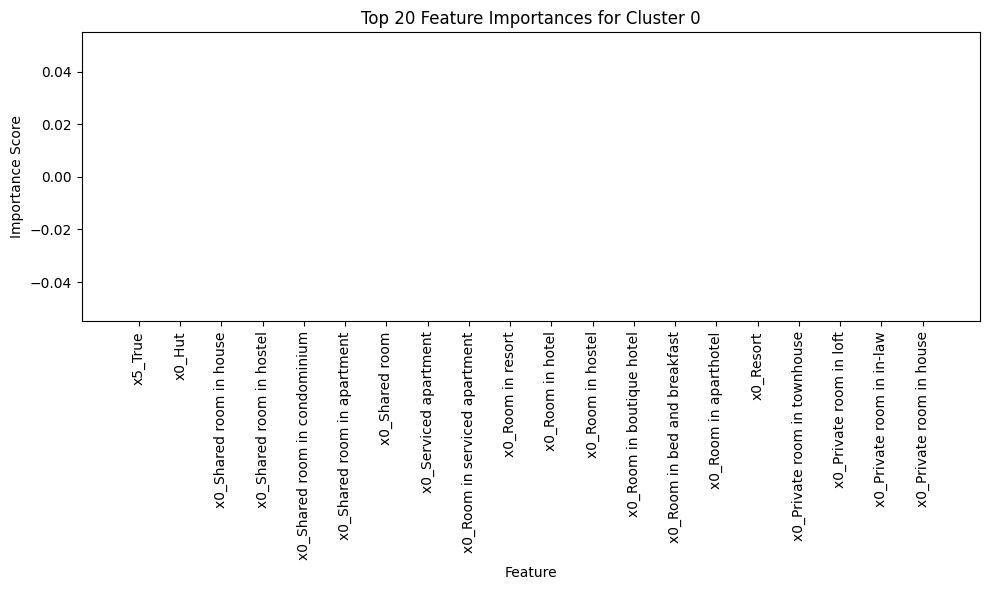

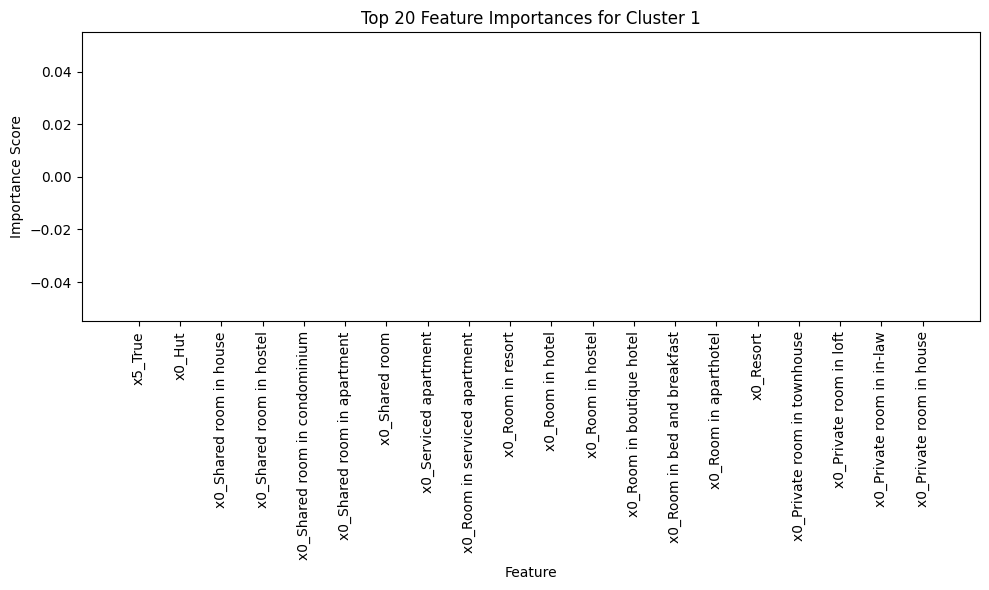

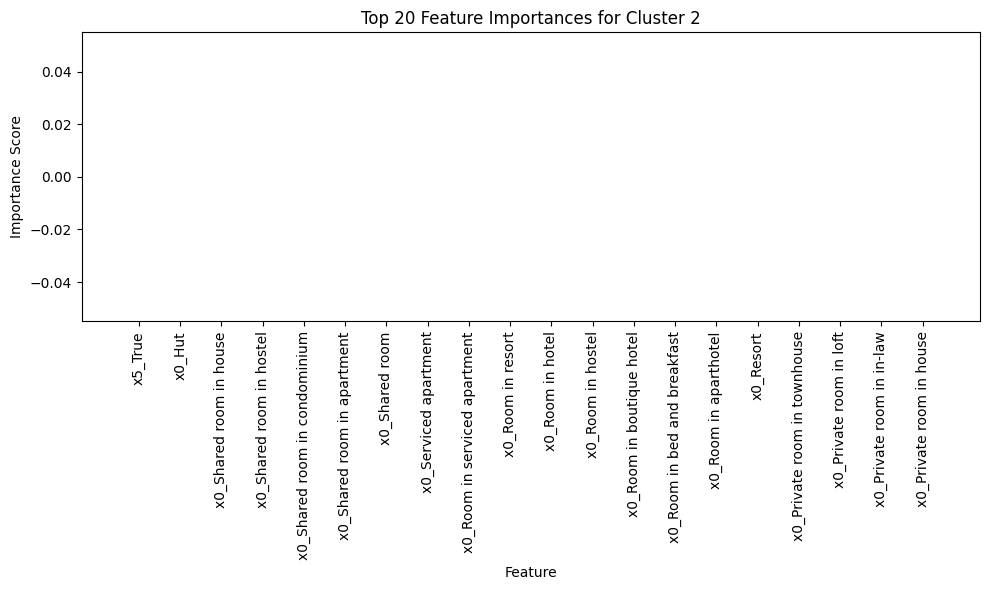

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/airbnb_Chicago.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Assuming that you have already added the 'Cluster' labels to your data
# ...

# Define numerical and categorical features
numerical_features = [
    'host_is_superhost_in_period', 'Bedrooms', 'Bathrooms', 'Max Guests',
    'Nightly Rate', 'Cleaning Fee (USD)', 'Minimum Stay',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'booked_days', 'revenue', 'occupancy_rate'
]

categorical_features = ['Property Type', 'Listing Type', 'City_x', 'Zipcode', 'Neighborhood', 'Pets Allowed']

# Preprocessing for numerical data: imputation followed by scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data: imputation followed by one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocessing the data
X = preprocessor.fit_transform(data)

# Retrieve the feature names from the preprocessor
ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out().tolist()
all_feature_names = numerical_features + ohe_feature_names

# Perform K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(X)

# Now generate the feature importance plots
for cluster in range(3):
    # Isolate the data for the current cluster
    cluster_data = data[data['Cluster'] == cluster]
    X_cluster = preprocessor.transform(cluster_data)

    # Create a Random Forest model and train it
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X_cluster, cluster_data['Cluster'])

    # Get feature importances
    importances = rf.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]

    # Plot the top 20 feature importances
    top_k = 20
    plt.figure(figsize=(10, 6))
    plt.title(f"Top {top_k} Feature Importances for Cluster {cluster}")
    plt.bar(range(top_k), importances[sorted_idx[:top_k]])
    plt.xticks(range(top_k), np.array(all_feature_names)[sorted_idx[:top_k]], rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


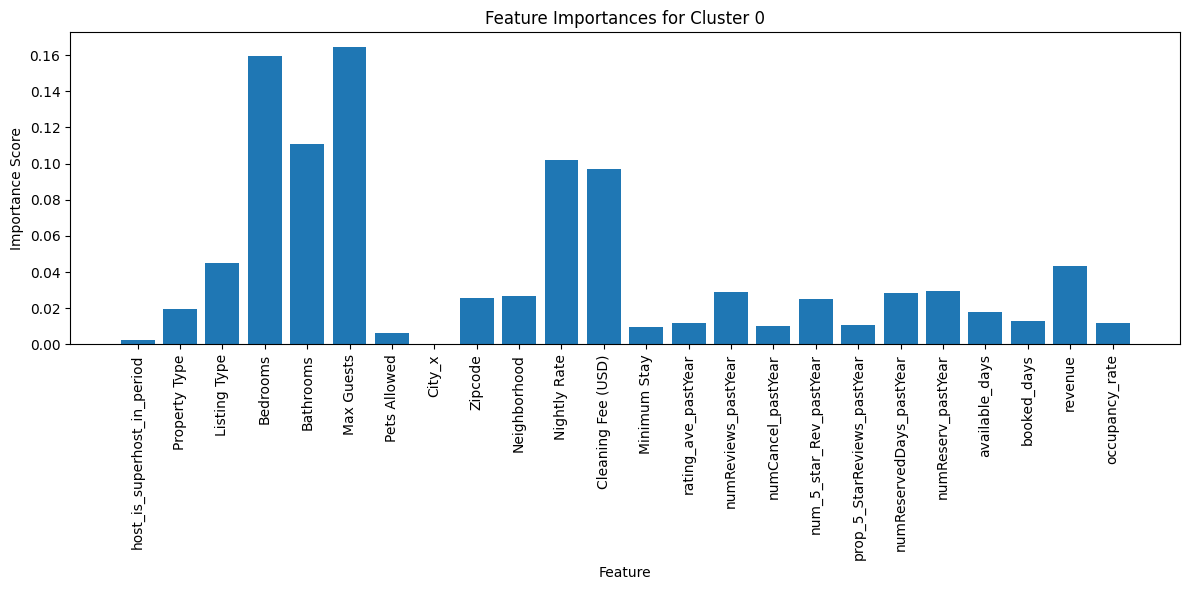

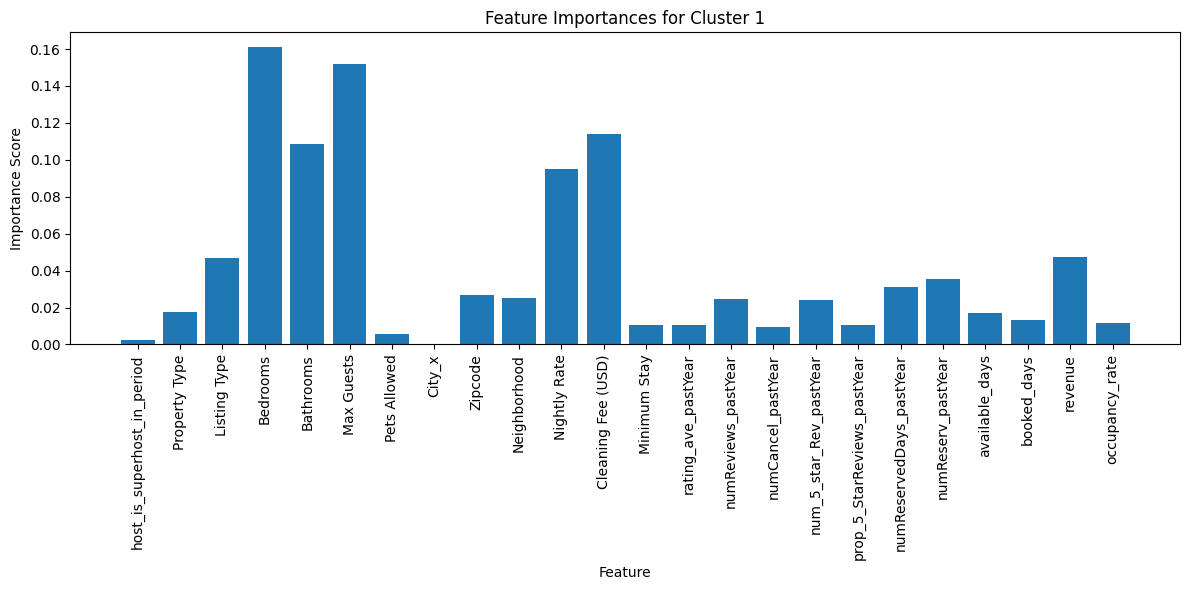

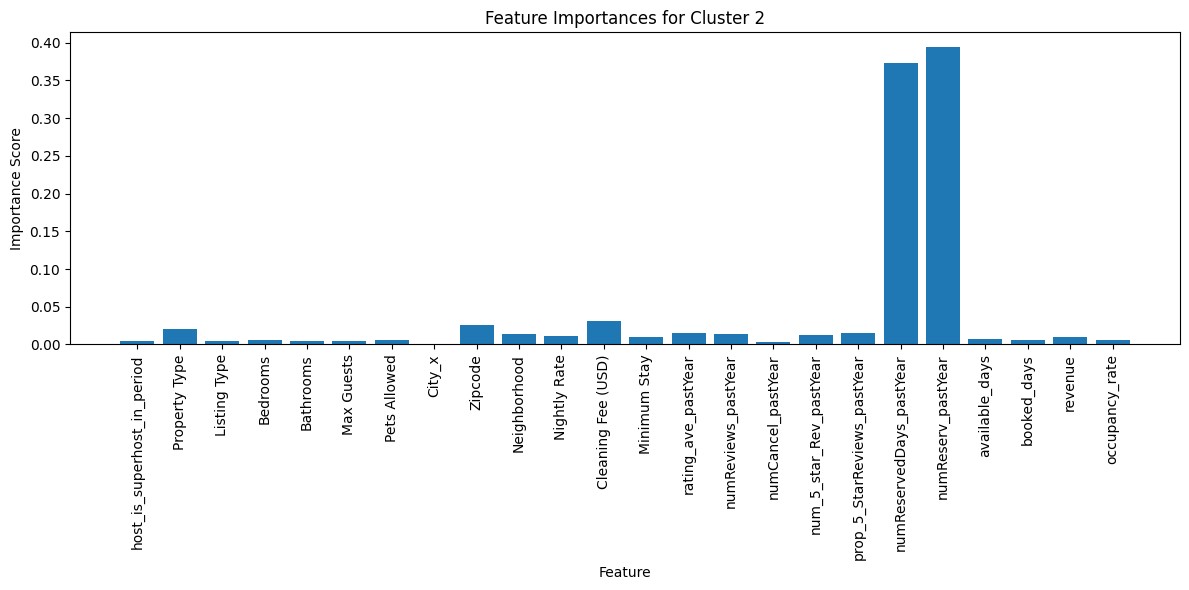

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = '/content/airbnb_Chicago.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Define the features to be used
features = [
    'host_is_superhost_in_period', 'Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Pets Allowed', 'City_x', 'Zipcode',
    'Neighborhood', 'Nightly Rate', 'Cleaning Fee (USD)', 'Minimum Stay',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'booked_days', 'revenue', 'occupancy_rate'
]

# Identify numerical and categorical features
categorical_features = ['Property Type', 'Listing Type', 'City_x', 'Zipcode', 'Neighborhood', 'Pets Allowed']
numerical_features = [f for f in features if f not in categorical_features]

# Impute missing values and scale numerical features
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Impute missing values and OneHotEncode categorical features
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ])

# Preprocess the data
X = preprocessor.fit_transform(data)

# Perform K-Means clustering with n_clusters=3
kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(X)

# Feature importance analysis for each cluster
for cluster in range(3):
    target = (data['Cluster'] == cluster).astype(int)
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X, target)

    importances = rf.feature_importances_

    # Get the feature names after OneHotEncoding
    onehot_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    onehot_importances = dict(zip(onehot_columns, importances[len(numerical_features):]))

    # Aggregate the importances for the one-hot encoded features
    aggregated_importances = {}
    for original_feature in categorical_features:
        aggregated_importances[original_feature] = sum(onehot_importances[name] for name in onehot_columns if name.startswith(original_feature))

    # Combine with the importances for numerical features
    for i, feature in enumerate(numerical_features):
        aggregated_importances[feature] = importances[i]

    # Sort features by importance
    sorted_features = sorted(aggregated_importances.items(), key=lambda item: item[1], reverse=True)

    # Plotting feature importances
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importances for Cluster {cluster}")
    plt.bar(range(len(features)), [aggregated_importances[feature] for feature in features], align='center')
    plt.xticks(range(len(features)), features, rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance Score')
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


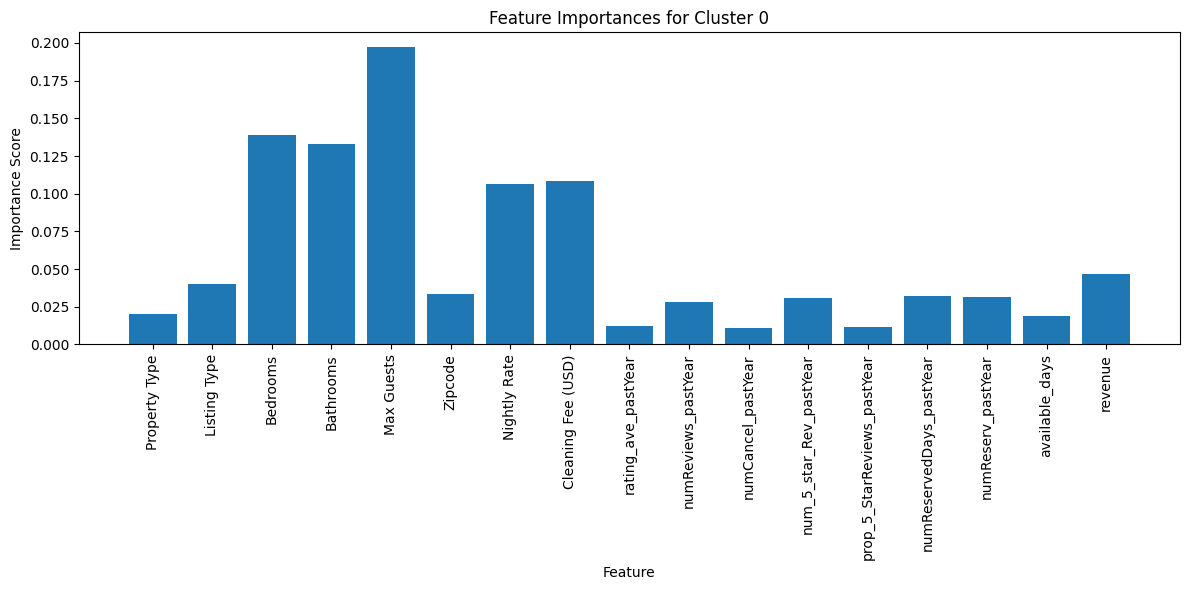

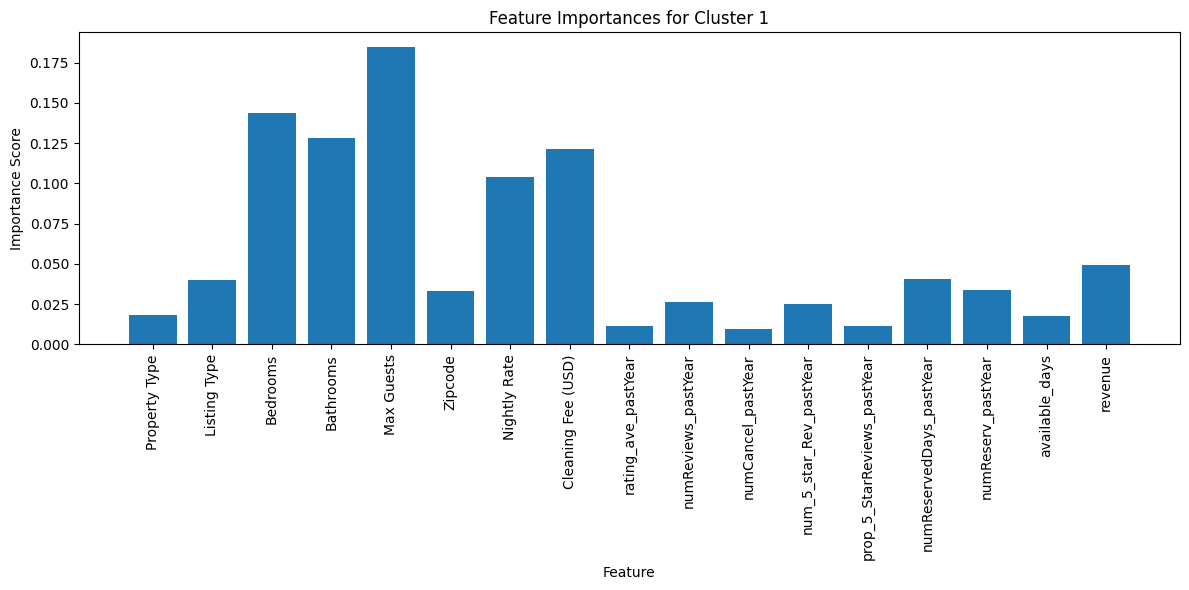

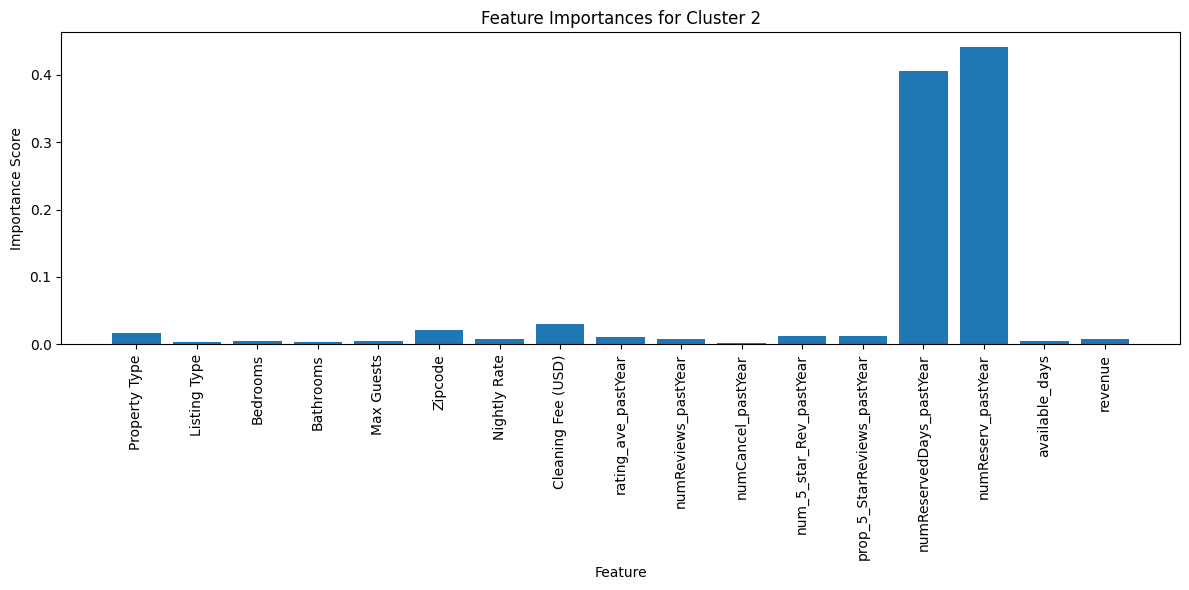

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = '/content/airbnb_Chicago.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)
data = data.dropna(subset=['revenue','Max Guests'])

# Define the features to be used
features = [
    'Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Nightly Rate', 'Cleaning Fee (USD)',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'revenue'
]

# Identify numerical features
numerical_features = [f for f in features if data[f].dtype in [np.float64, np.int64]]

# Remove outliers using IQR for numerical features
Q1 = data[numerical_features].quantile(0.25)
Q3 = data[numerical_features].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data_filtered = data[~((data[numerical_features] < lower_bound) | (data[numerical_features] > upper_bound)).any(axis=1)]


# Identify numerical and categorical features
categorical_features = ['Property Type', 'Listing Type', 'Zipcode']
numerical_features = [f for f in features if f not in categorical_features]

# Impute missing values and scale numerical features
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Impute missing values and OneHotEncode categorical features
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ])

# Preprocess the data
X = preprocessor.fit_transform(data)

# Perform K-Means clustering with n_clusters=3
kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(X)

# Feature importance analysis for each cluster
for cluster in range(3):
    target = (data['Cluster'] == cluster).astype(int)
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X, target)

    importances = rf.feature_importances_

    # Get the feature names after OneHotEncoding
    onehot_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    onehot_importances = dict(zip(onehot_columns, importances[len(numerical_features):]))

    # Aggregate the importances for the one-hot encoded features
    aggregated_importances = {}
    for original_feature in categorical_features:
        aggregated_importances[original_feature] = sum(onehot_importances[name] for name in onehot_columns if name.startswith(original_feature))

    # Combine with the importances for numerical features
    for i, feature in enumerate(numerical_features):
        aggregated_importances[feature] = importances[i]

    # Sort features by importance
    sorted_features = sorted(aggregated_importances.items(), key=lambda item: item[1], reverse=True)

    # Plotting feature importances
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importances for Cluster {cluster}")
    plt.bar(range(len(features)), [aggregated_importances[feature] for feature in features], align='center')
    plt.xticks(range(len(features)), features, rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance Score')
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Assuming 'X' is your feature matrix and 'labels' are the cluster labels from the clustering algorithm
silhouette_avg = silhouette_score(X, labels)
calinski_harabasz = calinski_harabasz_score(X, labels)
davies_bouldin = davies_bouldin_score(X, labels)

print(f"Silhouette Coefficient: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")
print(f"Davies-Bouldin Index: {davies_bouldin}")


NameError: ignored

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# Load the dataset
file_path = '/content/airbnb_Chicago.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)
# Define the features for which you want to drop rows with empty or null values
features_to_check = [
    'Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Nightly Rate', 'Cleaning Fee (USD)',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'revenue'
]

# Drop rows with any null values in the specified features
data.dropna(subset=features_to_check, inplace=True)

# Define the features to be used
features = [
    'Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Nightly Rate', 'Cleaning Fee (USD)',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'revenue'
]

# Identify numerical and categorical features
categorical_features = ['Property Type', 'Listing Type', 'Zipcode']
numerical_features = [f for f in features if f not in categorical_features]

# Impute missing values and scale numerical features
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Impute missing values and OneHotEncode categorical features
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ])

# Preprocess the data
X = preprocessor.fit_transform(data)

# Perform K-Means clustering with n_clusters=3
kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(X)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create a KMeans instance with the desired number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)

# Fit the model and predict clusters
data['Cluster'] = kmeans.fit_predict(features_scaled)

gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

# You would need to have a shapefile or GeoJSON file of Chicago to plot the base map
chicago_map = gpd.read_file('/content/chiacgo_geo.xlsx')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
chicago_map.plot(ax=ax, color='lightgrey')

# Plot the points from the GeoDataFrame
gdf.plot(ax=ax, column='Cluster', categorical=True, legend=True, markersize=10)

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: ignored

Below is the rf model for price optimization

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = '/content/airbnb_Chicago.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)
# Define the features for which you want to drop rows with empty or null values
features_to_check = [
    'Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Nightly Rate', 'Cleaning Fee (USD)',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'revenue'
]

# Drop rows with any null values in the specified features
data.dropna(subset=features_to_check, inplace=True)

# Define the features to be used
features = [
    'Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Nightly Rate', 'Cleaning Fee (USD)',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'revenue'
]

# Identify numerical and categorical features
categorical_features = ['Property Type', 'Listing Type', 'Zipcode']
numerical_features = [f for f in features if f not in categorical_features]

# Impute missing values and scale numerical features
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Impute missing values and OneHotEncode categorical features
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ])

# Preprocess the data
X = preprocessor.fit_transform(data)

# Perform K-Means clustering with n_clusters=3
kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(X)

# Feature importance analysis for each cluster
for cluster in range(3):
    target = (data['Cluster'] == cluster).astype(int)
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X, target)

    importances = rf.feature_importances_

    # Get the feature names after OneHotEncoding
    onehot_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    onehot_importances = dict(zip(onehot_columns, importances[len(numerical_features):]))

    # Aggregate the importances for the one-hot encoded features
    aggregated_importances = {}
    for original_feature in categorical_features:
        aggregated_importances[original_feature] = sum(onehot_importances[name] for name in onehot_columns if name.startswith(original_feature))

    # Combine with the importances for numerical features
    for i, feature in enumerate(numerical_features):
        aggregated_importances[feature] = importances[i]

    # Sort features by importance
    sorted_features = sorted(aggregated_importances.items(), key=lambda item: item[1], reverse=True)
# Manually determined significant features from the feature importance graphs for each cluster
# Replace the lists below with the actual significant features for each cluster
significant_features_cluster_0 = ['Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Cleaning Fee (USD)',
    'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear','revenue']
significant_features_cluster_1 = [ 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Cleaning Fee (USD)',
    'numReviews_pastYear','prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear','revenue']
significant_features_cluster_2 = ['numReviews_pastYear',
    'num_5_star_Rev_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear']

# Dictionary to hold the Random Forest models for each cluster
cluster_models = {}

# Assuming 'data' is the preprocessed data after dropping rows with NaNs for the specified features
# Assuming 'X' is the feature matrix after preprocessing and 'data['Cluster']' holds the cluster labels

# Dictionary to hold the Random Forest models for each cluster
cluster_models = {}

for cluster, significant_features in zip(range(3),
                                         [significant_features_cluster_0,
                                          significant_features_cluster_1,
                                          significant_features_cluster_2]):
    # Filter the data for the current cluster
    cluster_data = data[data['Cluster'] == cluster]

    # Ensure the significant features are present in the data
    significant_features = [feat for feat in significant_features if feat in cluster_data.columns]
    X_cluster = cluster_data[significant_features]

    # Identify categorical features present in the significant features
    significant_categorical_features = list(set(categorical_features) & set(significant_features))

    # OneHotEncode categorical features if present
    if significant_categorical_features:
        # Extract categorical data for encoding
        X_categorical = X_cluster[significant_categorical_features].astype(str)  # Ensure all categorical data is string type
        ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
        X_categorical_encoded = ohe.fit_transform(X_categorical)

        # Drop original categorical columns and concatenate encoded features
        X_cluster = X_cluster.drop(columns=significant_categorical_features)
        X_cluster = np.hstack((X_cluster, X_categorical_encoded))
    else:
        # If there are no categorical features, just use as is
        X_cluster = X_cluster.values

    # Target variable
    y_cluster = cluster_data['Nightly Rate']  # Assuming 'Nightly Rate' is the target variable

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=0)

    # Fit a Random Forest Regressor for the cluster
    rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
    rf_model.fit(X_train, y_train)

    # Store the model in the dictionary
    cluster_models[cluster] = rf_model

    # Evaluate the model on the test set
    y_pred = rf_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"RMSE for Cluster {cluster}: {rmse:.2f}")

# Now 'cluster_models' dictionary contains the fitted Random Forest models for each cluster


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


RMSE for Cluster 0: 134.91


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


RMSE for Cluster 1: 43.57
RMSE for Cluster 2: 74.20


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np

# Load the dataset
file_path = '/content/airbnb_Chicago.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)
# Define the features for which you want to drop rows with empty or null values
features_to_check = [
    'Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Nightly Rate', 'Cleaning Fee (USD)',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'revenue'
]

# Drop rows with any null values in the specified features
data.dropna(subset=features_to_check, inplace=True)

# Define the features to be used
features = [
    'Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Nightly Rate', 'Cleaning Fee (USD)',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'revenue'
]

# Identify numerical and categorical features
categorical_features = ['Property Type', 'Listing Type', 'Zipcode']
numerical_features = [f for f in features if f not in categorical_features]

# Impute missing values and scale numerical features
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Impute missing values and OneHotEncode categorical features
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ])

# Preprocess the data
X = preprocessor.fit_transform(data)

# Perform K-Means clustering with n_clusters=3
kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(X)

# Feature importance analysis for each cluster
for cluster in range(3):
    target = (data['Cluster'] == cluster).astype(int)
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X, target)

    importances = rf.feature_importances_

    # Get the feature names after OneHotEncoding
    onehot_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    onehot_importances = dict(zip(onehot_columns, importances[len(numerical_features):]))

    # Aggregate the importances for the one-hot encoded features
    aggregated_importances = {}
    for original_feature in categorical_features:
        aggregated_importances[original_feature] = sum(onehot_importances[name] for name in onehot_columns if name.startswith(original_feature))

    # Combine with the importances for numerical features
    for i, feature in enumerate(numerical_features):
        aggregated_importances[feature] = importances[i]

    # Sort features by importance
    sorted_features = sorted(aggregated_importances.items(), key=lambda item: item[1], reverse=True)
# Manually determined significant features from the feature importance graphs for each cluster
# Replace the lists below with the actual significant features for each cluster
significant_features_cluster_0 = ['Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Cleaning Fee (USD)',
    'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear','revenue']
significant_features_cluster_1 = [ 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Cleaning Fee (USD)',
    'numReviews_pastYear','prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear','revenue']
significant_features_cluster_2 = ['numReviews_pastYear',
    'num_5_star_Rev_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear']

# Dictionary to hold the Random Forest models for each cluster
cluster_models = {}

# Assuming 'data' is the preprocessed data after dropping rows with NaNs for the specified features
# Assuming 'X' is the feature matrix after preprocessing and 'data['Cluster']' holds the cluster labels

# Dictionary to hold the Random Forest models for each cluster
cluster_models = {}

for cluster, significant_features in zip(range(3),
                                         [significant_features_cluster_0,
                                          significant_features_cluster_1,
                                          significant_features_cluster_2]):
    # Filter the data for the current cluster
    cluster_data = data[data['Cluster'] == cluster]

    # Ensure the significant features are present in the data
    significant_features = [feat for feat in significant_features if feat in cluster_data.columns]
    X_cluster = cluster_data[significant_features]

    # Identify categorical features present in the significant features
    significant_categorical_features = list(set(categorical_features) & set(significant_features))

    # OneHotEncode categorical features if present
    if significant_categorical_features:
        # Extract categorical data for encoding
        X_categorical = X_cluster[significant_categorical_features].astype(str)  # Ensure all categorical data is string type
        ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
        X_categorical_encoded = ohe.fit_transform(X_categorical)

        # Drop original categorical columns and concatenate encoded features
        X_cluster = X_cluster.drop(columns=significant_categorical_features)
        X_cluster = np.hstack((X_cluster, X_categorical_encoded))
    else:
        # If there are no categorical features, just use as is
        X_cluster = X_cluster.values

    # Target variable
    y_cluster = cluster_data['Nightly Rate']  # Assuming 'Nightly Rate' is the target variable

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=0)

    # Fit a Random Forest Regressor for the cluster
    rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
    rf_model.fit(X_train, y_train)

    # Store the model in the dictionary
    cluster_models[cluster] = rf_model

    # Evaluate the model on the test set
    y_pred = rf_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"RMSE for Cluster {cluster}: {rmse:.2f}")

# Now 'cluster_models' dictionary contains the fitted Random Forest models for each cluster
kmeans = KMeans(n_clusters=3, random_state=0)
cluster_labels = kmeans.fit_predict(X)
data['Cluster'] = cluster_labels
#Dictionary to store optimized prices for each cluster
optimized_prices = {}

for cluster, model in cluster_models.items():
    # Retrieve the model for the current cluster
    rf_model = model

    # Filter the data for the current cluster
    cluster_data = data[data['Cluster'] == cluster]

    # Ensure the significant features are present in the data
    significant_features = [feat for feat in significant_features if feat in cluster_data.columns]
    X_cluster = cluster_data[significant_features]

    # OneHotEncode categorical features if present and concatenate them with numerical features
    if significant_categorical_features:
        X_categorical = X_cluster[significant_categorical_features].astype(str)
        ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
        X_categorical_encoded = ohe.fit_transform(X_categorical)
        X_numerical = X_cluster.drop(columns=significant_categorical_features)
        X_cluster = np.hstack((X_numerical, X_categorical_encoded))
    else:
        X_cluster = X_cluster.values

    # Create the optimal data point
    optimal_data_point = np.median(X_cluster, axis=0)

    # Ensure optimal data point has the same number of features as the training data
    # Pad with zeros if necessary
    num_features_model = rf_model.n_features_in_
    if optimal_data_point.shape[0] != num_features_model:
        optimal_data_point = np.pad(optimal_data_point, (0, num_features_model - optimal_data_point.shape[0]), 'constant')

    # Predict the optimized price using the model
    optimized_price = rf_model.predict(optimal_data_point.reshape(1, -1))[0]
    optimized_prices[cluster] = optimized_price

    print(f"Optimized price for Cluster {cluster}: ${optimized_price:.2f}")

    cluster_summary = data.groupby('Cluster').mean()

    print(cluster_summary)





/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


RMSE for Cluster 0: 134.65


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


RMSE for Cluster 1: 43.57
RMSE for Cluster 2: 74.20


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Optimized price for Cluster 0: $450.63
         Airbnb Host ID  Airbnb Property ID  superhost_period_all  \
Cluster                                                             
0          6.344054e+07        1.883470e+07             13.255669   
1          6.032824e+07        1.733764e+07             12.838800   
2          8.405441e+07        2.492537e+07             16.118246   

         scrapes_in_period  superhost_observed_in_period  \
Cluster                                                    
0                26.749063                     26.318872   
1                17.001418                     16.754415   
2               296.122569                    295.711948   

         host_is_superhost_in_period  superhost_ratio  \
Cluster                                                 
0                           0.462417         0.459549   
1                           0.455681         0.453674   
2                           0.348873         0.346016   

         prev_superhost_peri

<ipython-input-21-540c26230438>:210: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_summary = data.groupby('Cluster').mean()
<ipython-input-21-540c26230438>:210: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_summary = data.groupby('Cluster').mean()
<ipython-input-21-540c26230438>:210: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_summary = data.groupby('Cluster').mean()


IndentationError: ignored

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


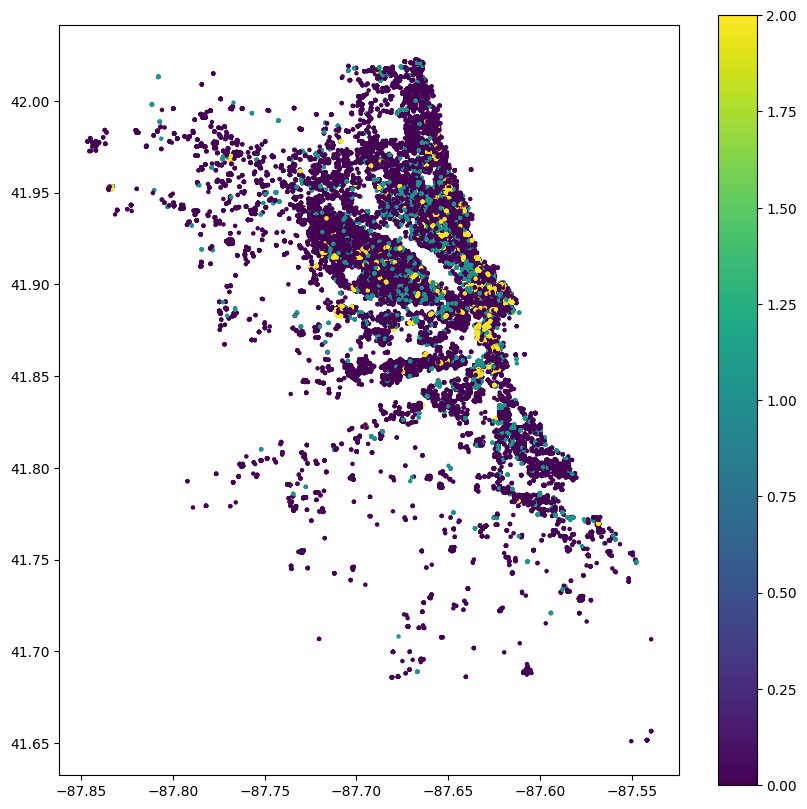

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# Load the dataset
file_path = '/content/airbnb_Chicago.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)
# Define the features for which you want to drop rows with empty or null values
features_to_check = [
    'Property Type', 'Listing Type', 'Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Nightly Rate', 'Cleaning Fee (USD)',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'revenue'
]

# Drop rows with any null values in the specified features
data.dropna(subset=features_to_check, inplace=True)

# StandardScaler to be applied only on numerical data
numerical_columns = ['Bedrooms',
    'Bathrooms', 'Max Guests', 'Zipcode',
    'Nightly Rate', 'Cleaning Fee (USD)',
    'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear',
    'num_5_star_Rev_pastYear', 'prop_5_StarReviews_pastYear',
    'numReservedDays_pastYear', 'numReserv_pastYear', 'available_days',
    'revenue']  # replace with actual numerical column names
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Create a KMeans instance with the desired number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)

# Perform K-Means clustering on the scaled numerical features
data['Cluster'] = kmeans.fit_predict(data[numerical_columns])

# Convert DataFrame to GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))

# Read the Chicago map shapefile or GeoJSON (you need to have this file)
chicago_map = gpd.read_file('/content/chiacgo_geo.csv')

# Plot the map with clusters
fig, ax = plt.subplots(figsize=(10, 10))
chicago_map.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(column='Cluster', ax=ax, markersize=5, legend=True, cmap='viridis')  # cmap can be any colormap string
plt.show()
